## Imports and Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from datetime import datetime
from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import prim

In [2]:
experiment_datetime = "base_case" ## change these 2 lines based on filename you want to read in
experiment_type = "100000_scenarios" ## "fixed_policies" or "generate_all"
results = load_results('./output/' + experiment_datetime + '_results__' + experiment_type + '.tar.gz')

In [3]:
experiments, outcomes = results
experiments.shape

(100000, 53)

----------------------------------------

## Pre-filtering Scenarios by Outcome

In [4]:
## FILTER OUT CASES W NO DAMAGE TO A.4
experiments_to_drop = []
for i, result in enumerate(outcomes['A.4 Expected Annual Damage']):
    if result == 0:
        experiments_to_drop.append(i)

experiments = experiments.drop(experiments_to_drop)
new_outcomes = {}
for key in outcomes:
    drop_index = 0
    new_outcomes[key] = np.array([])
    for i in range(len(outcomes[key])):
        if drop_index == len(experiments_to_drop):
            break
        elif i == experiments_to_drop[drop_index]:
            drop_index += 1
        else:
            new_outcomes[key] = np.append(new_outcomes[key], outcomes[key][i])
outcomes = new_outcomes

print(len(outcomes['A.4 Expected Annual Damage']))
results = (experiments, outcomes)

39633


---------------------------------------

## Visual Analysis

First, we can look at a pair-plotted scatter plot to visualize how our outcomes are related to each other and how differences in policy influence differences in outcomes. This is especially helpful if we are running analysis using hand-crafted policies or those decided on by the Directed Search proces.

In [5]:
# TODO: Make a 5-outcome PF and undo this part
# Drop outcomes which we aren't interested in:
outcomes_of_interest = ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths',
                        'Total Expected Annual Damage', 'Total Expected Number of Deaths',]

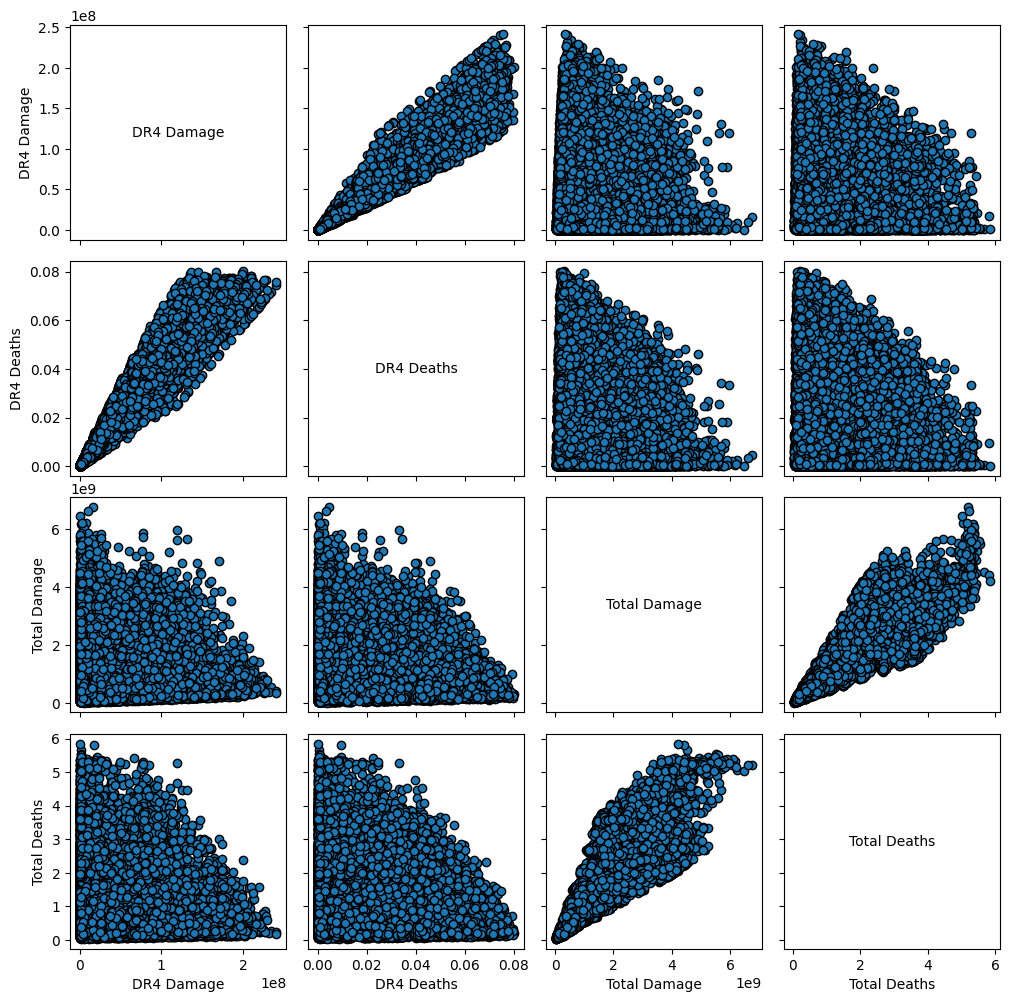

In [6]:
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest if k in outcomes}

ylabels = {
    'A.4 Expected Annual Damage'        : 'DR4 Damage',
    'A.4 Expected Number of Deaths'     : 'DR4 Deaths',
    'Total Expected Annual Damage'      : 'Total Damage',
    'Total Expected Number of Deaths'   : 'Total Deaths'
}
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset,
                                         legend=True, ylabels=ylabels,
                                         # edgecolor='none',
                                        )
fig.set_size_inches(12, 12)
plt.show()

In [7]:
ooi = 'A.4 Expected Annual Damage'

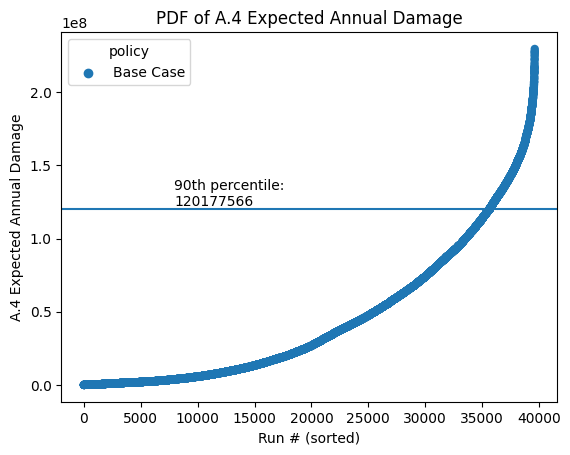

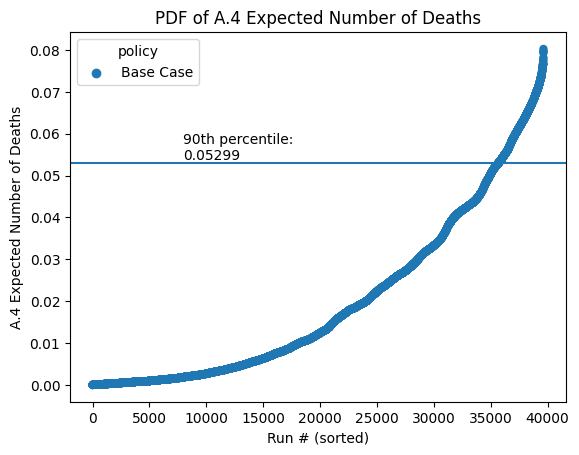

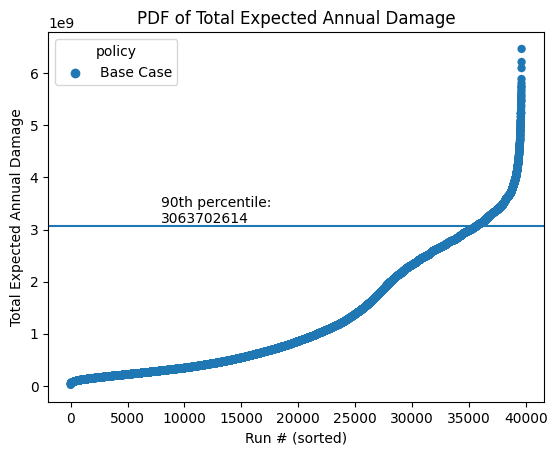

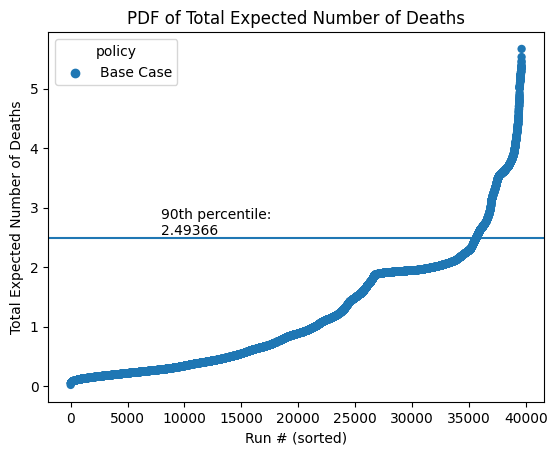

In [8]:
N = experiments.shape[0]
performance_threshold = None
# for outcome in outcomes_of_interest:
for col in outcomes_of_interest:
    # col = 'A.4 Expected Annual Damage'
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['x'] = np.arange(N)
    df = df.reset_index()
    
    # plot
    ax = sns.scatterplot(data=df, x='x', y=col, hue='policy',
                         legend='full', alpha=1, linewidth=0,
                         palette='tab10')

    # draw a line at the 95th percentile
    ninety = int(N*0.9)
    twenty = int(N*0.2)
    ax.axhline(df[col][ninety], label=str(df[col][ninety]))
    if col.split()[-1] == 'Deaths':
        ax.annotate(text=f"90th percentile:\n{df[col][ninety]:.5f}", xy=(twenty, df[col][ninety]),
                    xytext=(0, 3), textcoords='offset pixels')
    else:
        ax.annotate(text=f"90th percentile:\n{df[col][ninety]:.0f}", xy=(twenty, df[col][ninety]),
                    xytext=(0, 3), textcoords='offset pixels')
    
    # save performance threshold
    if (col == ooi):
        performance_threshold = df[col][ninety]

    # graph setup
    plt.title('PDF of '+col)
    plt.xlabel('Run # (sorted)')
    plt.ylabel(col)
    plt.show()

-----------------------------------

## Scenario Discovery

put words here to describe what we're doing and why

In [9]:
uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax',
                 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax',
                 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail',
                 'discount rate 0', 'discount rate 1', 'discount rate 2',]

In [10]:
# x = experiments
# y = outcomes[ooi] > performance_threshold
# prim_alg = prim.Prim(x, y,
#                      threshold=0.75,
#                      peel_alpha=0.1,
#                      mass_min=0.001,
#                      )
prim_alg = prim.setup_prim(results,
                           classify=lambda y: y[ooi] > performance_threshold,
                           threshold=0.75,
                           incl_unc=uncertainties,
                           mass_min=0.01
                           )
box1 = prim_alg.find_box()

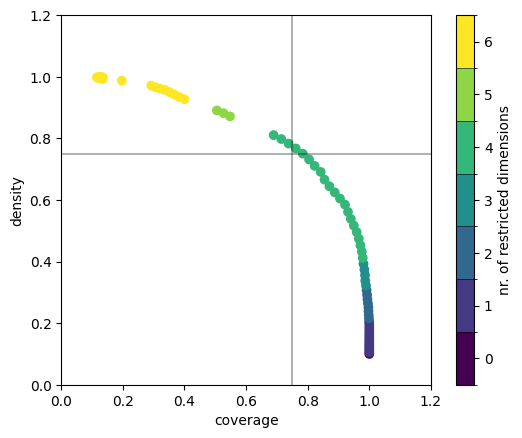

In [11]:
box1.show_tradeoff()
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='k', alpha=0.3)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='k', alpha=0.3)
plt.show()

In [12]:
traject = box1.peeling_trajectory
traject[(traject.coverage > 0.75) & (traject.density > 0.75)]
# 2 possible boxes -- select higher mass

,coverage,density,id,mass,mean,res_dim
44,0.784002,0.750302,44,0.104484,0.750302,4
45,0.761292,0.767099,45,0.099235,0.767099,4


In [13]:
# TODO: based on max density of filtered traject
best_box_idx = 45
box1.select(best_box_idx)

coverage     0.761292
density      0.767099
id          45.000000
mass         0.099235
mean         0.767099
res_dim      4.000000
Name: 45, dtype: float64

             box 45                                  
                min       max       qp value qp value
A.4_pfail  0.000006  0.093803            NaN      0.0
A.1_pfail  0.369174  0.999989  7.565026e-235      NaN
A.3_pfail  0.247092  0.999985   3.976542e-80      NaN
A.2_pfail  0.123342  0.999982   1.250991e-22      NaN



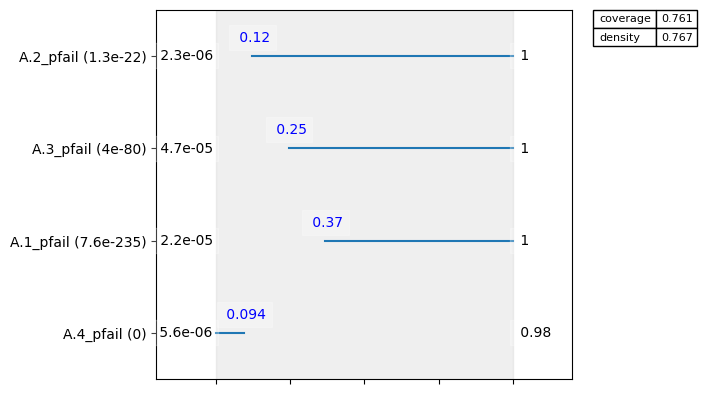

In [14]:
box1.inspect()
box1.inspect(style="graph")
plt.show()

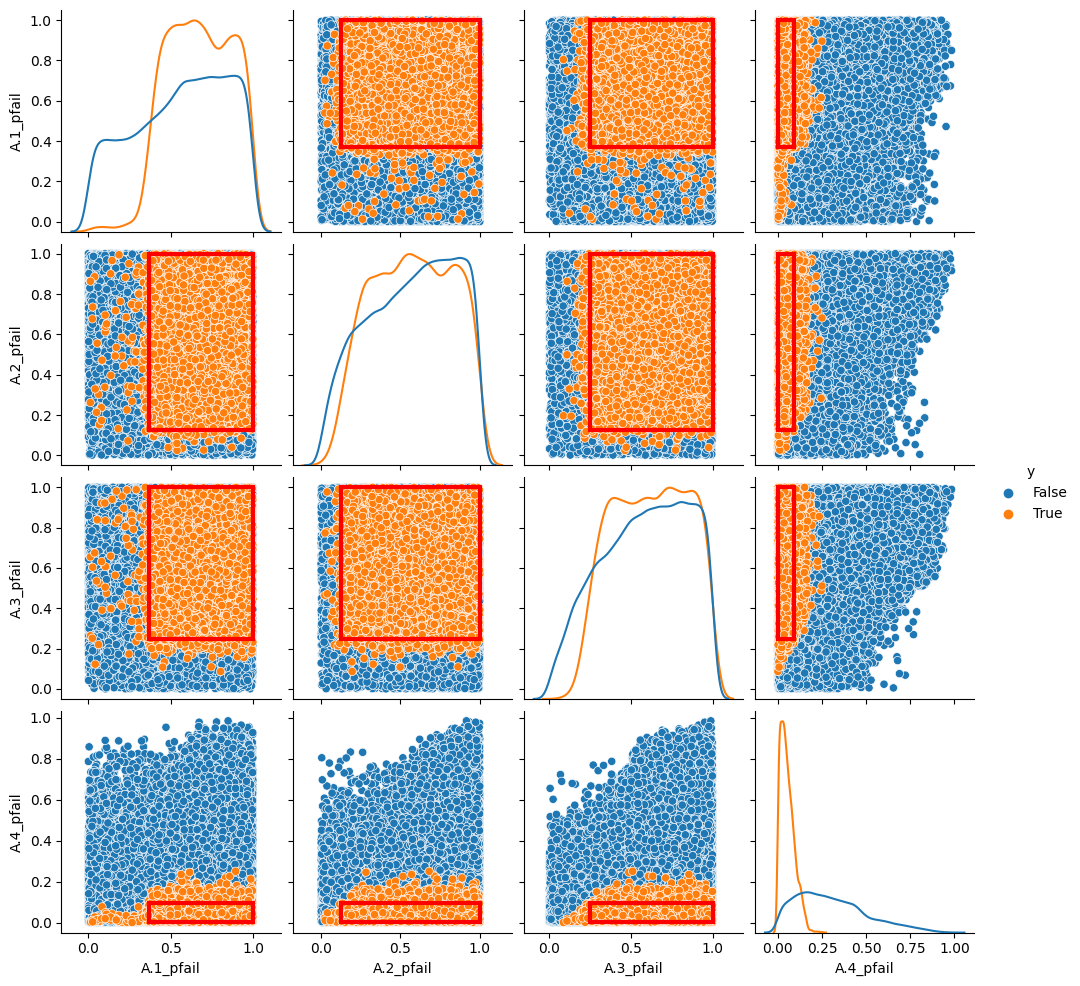

In [15]:
box1.show_pairs_scatter()
plt.show()

In [16]:
limits = box1.box_lims[best_box_idx]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.018626,"{1.5, 10.0, 1.0}",0.369174,30.018827,"{1.5, 10.0, 1.0}",0.123342,30.002562,"{1.0, 10.0, 1.5}",0.247092,30.022694,"{1.0, 10.0, 1.5}",0.000006,30.016911,"{1.5, 10.0, 1.0}",0.000010,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.991644,"{1.5, 10.0, 1.0}",0.999989,349.990873,"{1.5, 10.0, 1.0}",0.999982,349.996053,"{1.0, 10.0, 1.5}",0.999985,349.999154,"{1.0, 10.0, 1.5}",0.093803,349.980059,"{1.5, 10.0, 1.0}",0.999974,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


--------------------------

## Filter, Sort, and Save Outputs

In [17]:
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]
combined_df['Within Limit'] = True
combined_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths,Within Limit
0,63,101.259903,1.5,0.408709,111.632141,1.5,0.135391,73.153987,1.0,0.451986,...,2.728748e+07,0.041352,8.757227e+06,0.003369,0.000000e+00,0.000000,0.0,1.723623e+09,1.132815,True
5,43,61.921647,1.5,0.047811,56.262052,1.5,0.017475,311.766050,1.5,0.162441,...,4.588641e+08,0.618858,1.089178e+06,0.000370,0.000000e+00,0.000000,0.0,5.245450e+09,3.320664,True
6,68,46.765651,10.0,0.822219,219.181706,1.0,0.807496,282.354956,1.5,0.910047,...,2.832855e+07,0.061809,5.042158e+05,0.000339,4.436058e+08,0.472837,0.0,4.992548e+08,0.564465,True
7,109,59.067851,10.0,0.145279,337.123645,1.5,0.279685,318.667608,10.0,0.304903,...,3.231852e+08,0.525432,2.398455e+07,0.010036,8.355113e+06,0.006937,0.0,3.551046e+09,2.535472,True
9,129,139.473910,10.0,0.260311,203.502199,1.5,0.428188,245.749023,10.0,0.669542,...,0.000000e+00,0.000000,5.565392e+06,0.002156,0.000000e+00,0.000000,0.0,3.351856e+09,1.876356,True


In [18]:
print(combined_df.shape)

(39633, 67)


In [19]:
# Apply PRIM constraint
for idx, row in combined_df.iterrows():
    for unc in limits:
        if (type(limits.loc[0, unc]) == set):
            if row[unc] not in limits.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limits.loc[0, unc] or row[unc] > limits.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [20]:
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
combined_df.shape

(3933, 66)

In [21]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.2 Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
71789,98,245.492589,1.5,0.730879,103.700541,1.5,0.811144,212.666805,1.5,0.966618,...,0.023369,2.304640e+07,0.031816,2.412142e+08,0.075778,0.0,0.0,0.0,3.414177e+08,0.155714
71139,23,262.554875,10.0,0.969102,280.377067,10.0,0.526979,187.570341,1.0,0.696104,...,0.094929,3.469710e+07,0.046798,2.409890e+08,0.074537,0.0,0.0,0.0,4.098237e+08,0.216264
11550,60,275.708351,1.0,0.572317,265.693511,1.5,0.420025,121.947334,10.0,0.759597,...,0.093453,0.000000e+00,0.000000,2.344626e+08,0.071654,0.0,0.0,0.0,5.497785e+08,0.262440
23082,40,62.466739,1.5,0.880597,136.376759,1.5,0.461343,142.623248,10.0,0.675062,...,0.094292,3.229027e+07,0.043697,2.319523e+08,0.070747,0.0,0.0,0.0,3.979242e+08,0.208735
98457,27,262.062862,10.0,0.563094,193.450856,10.0,0.674911,273.473465,1.5,0.496738,...,0.037259,2.576351e+08,0.345692,2.294862e+08,0.072420,0.0,0.0,0.0,7.903236e+08,0.588542


In [22]:
combined_df.to_csv('output/base_case_results__100000_scenarios__prim_filtered.csv', index=True)

### Finding a Diverse Scenario Set

We want to construct a 4-scenario set that includes our worst-case scenario and also maximizes diversity within the set.

In [23]:
combined_df = pd.read_csv('output/base_case_results__100000_scenarios__prim_filtered.csv')
combined_df.shape

(3933, 67)

In [57]:
# # Reset index and create a mapping
# mapping = {}
# reverse = {}
# for idx, row in combined_df.iterrows():
#     mapping[row['Run ID']] = idx
#     reverse[idx] = row['Run ID']

In [58]:
# combinations_in_normalized_outcomes = []
# for c in combinations:
#     mapped_c = [mapping[x] for x in c]
#     combinations_in_normalized_outcomes.append(tuple(mapped_c))

In [59]:
# most_diverse_set = [reverse[x] for x in most_diverse[1]]
# most_diverse_set

In [24]:
most_diverse_set = [54840, 91325, 74784, 71789]

In [25]:
combined_df = combined_df.rename({'Unnamed: 0': 'Run ID'}, axis=1)
combined_df = combined_df.set_index('Run ID')
combined_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.2 Expected Number of Deaths,A.3 Expected Annual Damage,A.3 Expected Number of Deaths,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,A.5 Expected Annual Damage,A.5 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
Run ID,,,,,,,,,,,,,,,,,,,,,
71789,98,245.492589,1.5,0.730879,103.700541,1.5,0.811144,212.666805,1.5,0.966618,...,0.023369,2.304640e+07,0.031816,2.412142e+08,0.075778,0.0,0.0,0.0,3.414177e+08,0.155714
71139,23,262.554875,10.0,0.969102,280.377067,10.0,0.526979,187.570341,1.0,0.696104,...,0.094929,3.469710e+07,0.046798,2.409890e+08,0.074537,0.0,0.0,0.0,4.098237e+08,0.216264
11550,60,275.708351,1.0,0.572317,265.693511,1.5,0.420025,121.947334,10.0,0.759597,...,0.093453,0.000000e+00,0.000000,2.344626e+08,0.071654,0.0,0.0,0.0,5.497785e+08,0.262440
23082,40,62.466739,1.5,0.880597,136.376759,1.5,0.461343,142.623248,10.0,0.675062,...,0.094292,3.229027e+07,0.043697,2.319523e+08,0.070747,0.0,0.0,0.0,3.979242e+08,0.208735
98457,27,262.062862,10.0,0.563094,193.450856,10.0,0.674911,273.473465,1.5,0.496738,...,0.037259,2.576351e+08,0.345692,2.294862e+08,0.072420,0.0,0.0,0.0,7.903236e+08,0.588542


In [26]:
combined_df['Dike Rings 1 & 2 Damage/Year'] =     \
        combined_df['A.1 Expected Annual Damage'] + \
        combined_df['A.2 Expected Annual Damage']

combined_df = combined_df.rename({
    'A.4 Expected Annual Damage'    : 'Dike Ring 4 Damage/Year',
    'Total Expected Annual Damage'  : 'Total Damage/Year',
}, axis=1)

outcomes_of_interest = ['Dike Rings 1 & 2 Damage/Year',
                        'Dike Ring 4 Damage/Year',
                        'Total Damage/Year']

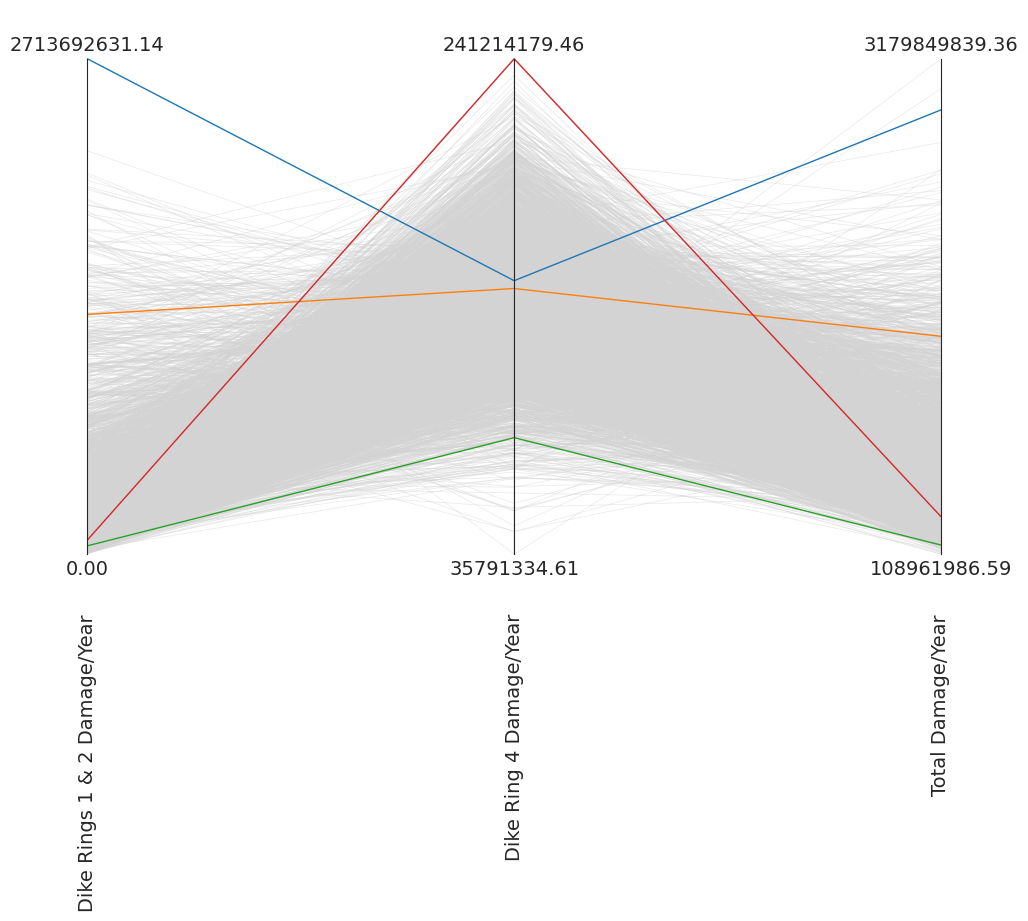

In [28]:
from ema_workbench.analysis import parcoords

# conditional on y

outcomes_df = combined_df[outcomes_of_interest]

limits = parcoords.get_limits(outcomes_df)
axes = parcoords.ParallelAxes(limits)

# we set the linewidth lower, and make the lines slightly transpartant using alpha
# this often helps reveal patterns in the results.
axes.plot(outcomes_df, color='lightgrey', lw=0.5, alpha=0.5)
for i, scenario in enumerate(most_diverse_set):
    axes.plot(outcomes_df.loc[scenario, :], color=sns.color_palette()[i], lw=1)

fig = plt.gcf()
fig.set_size_inches((12, 20))

plt.show()